# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


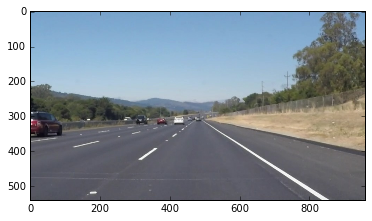

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [139]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# global vars (we are not using classes) to keep track of slopes and x coordinate values across calls to draw_lines
right_slope, left_slope, right_x0, right_x1, left_x0, left_x1 = None, None, None, None, None, None


def reset_global_draw_line_vars():
    global right_slope, left_slope, right_x0, right_x1, left_x0, left_x1
    right_slope, left_slope, right_x0, right_x1, left_x0, left_x1 = None, None, None, None, None, None


def low_pass_filter(x, y, alpha):
    """
    helper function to ensure smoother lines during transition between frames with help of global vars
    """
    return x*alpha + y*(1-alpha)


def draw_lines(img, lines, color=[0, 255, 0], thickness=5):
    imshape = img.shape
    global right_slope, left_slope, right_x0, right_x1, left_x0, left_x1
    right_slope_limits = (0.4, 0.9)
    left_slope_limits = (-0.4, -0.9)
    right_slope_points, left_slope_points = [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            if right_slope_limits[0] < slope < right_slope_limits[1]:
                right_slope_points.extend([(x1,y1), (x2,y2)])
            elif left_slope_limits[1] < slope < left_slope_limits[0]:
                left_slope_points.extend([(x1,y1), (x2,y2)])
            else:
                continue

    if right_slope_points and left_slope_points:
        current_right_slope_limits = (0.5, 0.8)
        current_left_slope_limits = (-0.5, -0.8)
        # find starting coordinates (i.e. coordinates in upper half of image)
        # for both lines having positive slope and negative slopes
        # choose minimum y coordinate point i.e. top most point
        right_starting_point = min(right_slope_points, key=lambda x: x[1])
        left_starting_point = min(left_slope_points, key=lambda x: x[1])

        # fit lines through the right points
        vx, vy, x, y = cv2.fitLine(np.array(right_slope_points), cv2.DIST_L2, 0, 0.01, 0.01)
        current_slope = vy/vx
        # weighting for newer values of slope and x coords. If we have lots of data points we give higher value to new readings
        right_alpha = 0.6 if len(right_slope_points) > 5 else 0.8
        # check current slope is not noisy i.e. fall outside limits
        if current_right_slope_limits[0] < current_slope < current_right_slope_limits[1]:
            if right_slope is None:
                right_slope = current_slope
            else:
                right_slope = low_pass_filter(right_slope, current_slope, right_alpha)

            x0 = ((right_starting_point[1] - y)/right_slope) + x
            if right_x0 is None:
                right_x0 = x0
            else:
                right_x0 = low_pass_filter(right_x0, x0, right_alpha)

            x1 = math.ceil(((imshape[0] - y)/right_slope) + x)
            if right_x1 is None:
                right_x1 = x1
            else:
                right_x1 = low_pass_filter(right_x1, x1, right_alpha)

            cv2.line(img, (math.floor(right_x0), right_starting_point[1]), (math.floor(right_x1), imshape[0]), color, thickness)

        # repeat process for left points
        vx, vy, x, y = cv2.fitLine(np.array(left_slope_points), cv2.DIST_L2, 0, 0.01, 0.01)
        current_slope = vy/vx
        # same reasoning as right_alpha above
        left_alpha = 0.6 if len(left_slope_points) > 5 else 0.8
        # check current slope is not noisy i.e. fall outside limits
        if current_left_slope_limits[1] < current_slope < current_left_slope_limits[0]:
            if left_slope is None:
                left_slope = current_slope
            else:
                left_slope = low_pass_filter(left_slope, current_slope, left_alpha)

            x0 = ((left_starting_point[1] - y)/left_slope) + x
            if left_x0 is None:
                left_x0 = x0
            else:
                left_x0 = low_pass_filter(left_x0, x0, left_alpha)

            x1 = math.ceil(((imshape[0] - y)/left_slope) + x)
            if left_x1 is None:
                left_x1 = x1
            else:
                left_x1 = low_pass_filter(left_x1, x1, left_alpha)

            cv2.line(img, (math.floor(left_x0), left_starting_point[1]), (math.floor(left_x1), imshape[0]), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    #print("Image Shape ", img.shape)
    #print("Original Image Shape ", initial_img.shape)

    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [51]:
import os
DIR_NAME = "test_images/"
test_images = os.listdir(DIR_NAME)

run your solution on all test_images and make copies into the test_images directory).

Processing image file  solidWhiteCurve.jpg
Processing image file  solidWhiteRight.jpg
Processing image file  solidYellowCurve.jpg
Processing image file  solidYellowCurve2.jpg
Processing image file  solidYellowLeft.jpg
Processing image file  whiteCarLaneSwitch.jpg


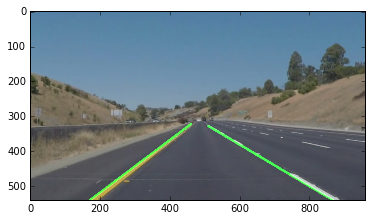

In [140]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def processing_pipeline(funcs, img, settings):
    for func in funcs:
        function_name = func.__name__
        args = settings.get(function_name)
        img = func(img, *args) if args else func(img)
    return img

for image_file in test_images:
    print("Processing image file ", image_file)
    img = mpimg.imread(DIR_NAME + image_file)
    imshape = img.shape
    img_height, img_width = imshape[0], imshape[1]
    original_img = np.copy(img)
    funcs = [grayscale, gaussian_blur, canny, region_of_interest, hough_lines, weighted_img]
    function_settings = {
        'grayscale': [],
        'canny': [50, 150],
        'gaussian_blur': [5],
        'region_of_interest': [np.array([[(math.ceil(img_width/5), img_height), (math.ceil(img_width/4), math.ceil(3*img_height/5)),
                                          (math.ceil(4*img_width/5), math.ceil(3*img_height/5)), (img_width, img_height)]], dtype=np.int32)],
        'hough_lines': [1, np.pi/180, 50, 100, 70],
        'weighted_img': [original_img, 0.8, 1., 0.],
    }
    output_image = processing_pipeline(funcs, img, function_settings)
    # save output image to DIR_NAME
    #mpimg.imsave(DIR_NAME + "processed" + image_file[0].upper() + image_file[1:], output_image)
    plt.imshow(output_image)





## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [135]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    funcs = [grayscale, gaussian_blur, canny, region_of_interest, hough_lines, weighted_img]
    imshape = image.shape
    img_height, img_width = imshape[0], imshape[1]
    function_settings = {
        'grayscale': [],
        'canny': [50, 150],
        'gaussian_blur': [5],
        'region_of_interest': [np.array([[(math.ceil(img_width/5), img_height), (math.ceil(img_width/4), math.ceil(3*img_height/5)),
                                          (math.ceil(4*img_width/5), math.ceil(3*img_height/5)), (img_width, img_height)]], dtype=np.int32)],
        'hough_lines': [2, np.pi/180, 40, 30, 200],
        'weighted_img': [image, 0.8, 1., 0.],
    }
    result = processing_pipeline(funcs, image, function_settings)
    return result

Let's try the one with the solid white lane on the right first ...

In [141]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_global_draw_line_vars()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  2%|▏         | 4/222 [00:00<00:05, 38.51it/s]





  5%|▍         | 10/222 [00:00<00:04, 42.92it/s]





  7%|▋         | 15/222 [00:00<00:04, 43.06it/s]





  9%|▊         | 19/222 [00:00<00:05, 39.06it/s]





 11%|█         | 24/222 [00:00<00:04, 40.46it/s]





 13%|█▎        | 28/222 [00:00<00:04, 40.12it/s]





 15%|█▍        | 33/222 [00:00<00:04, 41.28it/s]





 17%|█▋        | 38/222 [00:00<00:04, 43.34it/s]





 20%|█▉        | 44/222 [00:01<00:03, 44.62it/s]





 22%|██▏       | 49/222 [00:01<00:08, 20.80it/s]





 24%|██▍       | 53/222 [00:01<00:09, 17.63it/s]





 25%|██▌       | 56/222 [00:01<00:08, 19.31it/s]





 27%|██▋       | 59/222 [00:02<00:09, 17.08it/s]





 28%|██▊       | 62/222 [00:02<00:09, 17.14it/s]





 29%|██▉       | 65/222 [00:02<00:09, 16.71it/s]





 30%|███       | 67/222 [00:02<00:09, 15.83it/s]





 31%|███       | 69/222 [00:02<00:09, 16.51it/s]





 32%|███▏      | 72/222 [00:02<0

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.96 s, sys: 1.03 s, total: 4.99 s
Wall time: 11.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [144]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [142]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
reset_global_draw_line_vars()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  1%|          | 5/682 [00:00<00:15, 43.35it/s]





  2%|▏         | 11/682 [00:00<00:14, 47.11it/s]





  3%|▎         | 18/682 [00:00<00:13, 51.05it/s]





  3%|▎         | 23/682 [00:00<00:13, 48.04it/s]





  4%|▍         | 27/682 [00:00<00:15, 42.70it/s]





  5%|▍         | 31/682 [00:00<00:15, 40.71it/s]





  5%|▌         | 37/682 [00:00<00:14, 44.58it/s]





  6%|▋         | 43/682 [00:00<00:13, 47.78it/s]





  7%|▋         | 48/682 [00:01<00:32, 19.50it/s]





  8%|▊         | 52/682 [00:01<00:32, 19.28it/s]





  8%|▊         | 56/682 [00:01<00:36, 17.16it/s]





  9%|▊         | 59/682 [00:02<00:37, 16.51it/s]





  9%|▉         | 62/682 [00:02<00:36, 16.81it/s]





 10%|▉         | 65/682 [00:02<00:37, 16.59it/s]





 10%|▉         | 67/682 [00:02<00:38, 16.18it/s]





 10%|█         | 70/682 [00:02<00:33, 18.48it/s]





 11%|█         | 73/682 [00:02<00:29, 20.69it/s]





 11%|█         | 76/682 [00:03<0

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.9 s, sys: 1.45 s, total: 13.3 s
Wall time: 29.9 s


In [143]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Ways to make my submission better (probably not exhaustive):
1) Find a better way of drawing smoother transitions when slopes change more abruptly (like in the challenge video). Right now I am trying to use a low pass filter but the weight for it has been chosen just based on some images and not in any scientific manner, which means it will probably not generalize well (and it does not in the challenge video). Perhaps try something like Kalman filters.

2) Once again the parameters for hough_lines, canny detection are all static, they do not adapt to the given frame/image. So I can imagine a situation where the car is passing through a shaded area (e.g. tunnel), or goes through an area with a lot of dust etc, and the line detection will be thrown awry due to the static paramters. So would be ideal to have these params adapt to the conditions around them.





## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [145]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4








  0%|          | 0/251 [00:00<?, ?it/s]





  1%|          | 3/251 [00:00<00:10, 24.36it/s]





  2%|▏         | 6/251 [00:00<00:10, 23.98it/s]





  3%|▎         | 8/251 [00:00<00:10, 22.36it/s]





  4%|▍         | 11/251 [00:00<00:10, 22.89it/s]





  6%|▌         | 14/251 [00:00<00:09, 23.99it/s]





  7%|▋         | 17/251 [00:00<00:09, 23.65it/s]





  8%|▊         | 20/251 [00:00<00:09, 24.20it/s]





  9%|▉         | 23/251 [00:00<00:09, 24.59it/s]





 10%|█         | 26/251 [00:01<00:09, 24.59it/s]





 12%|█▏        | 29/251 [00:01<00:08, 25.22it/s]





 13%|█▎        | 32/251 [00:01<00:08, 25.53it/s]





 14%|█▍        | 35/251 [00:01<00:09, 23.33it/s]





 15%|█▌        | 38/251 [00:01<00:09, 22.47it/s]





 16%|█▋        | 41/251 [00:01<00:09, 22.84it/s]





 18%|█▊        | 44/251 [00:01<00:08, 23.05it/s]





 19%|█▊        | 47/251 [00:02<00:13, 15.36it/s]





 20%|█▉        | 49/251 [00:02<00:16, 12.33it/s]





 20%|██        | 51/251 [00:02<00:

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.81 s, sys: 2.09 s, total: 11.9 s
Wall time: 32.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))